In [1]:
import cv2
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()

        output = self.model(x)

        if output.ndim == 1 or output.shape[1] == 1:
            score = output.squeeze()
        else:
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            score = output[:, class_idx]

        score.backward(retain_graph=True)

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        cam = cam.cpu().numpy()[0]
        return cam

In [3]:
class CNN(nn.Module):
    """
    1st layer: 1 input channel (greyscale image), 16 output channels (feature maps),
    3×3 kernels initialised randomly and learned during training.

    params = in_ch * out_ch * kernel h * kernel w + one bias per out_ch
    e.g.: 1 * 16 * 3 * 3 + 16 = 160
          16 * 32 * 3 * 3 + 32 = 4640

    nn.MaxPool2d(2, 2) has kernel size 2×2 and stride 2×2, reduces spacial dims by half.

    self.fc maps 64 neurons to 2 output classes
    """
    def __init__(self):
        # super() in Python calls methods of a parent class
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 128, 3, padding="same")

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        self.mpool = nn.MaxPool2d(2, 2)
        self.apool = nn.AdaptiveAvgPool2d((4,4))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.mpool(F.relu(self.bn1(self.conv1(x))))
        x = self.mpool(F.relu(self.bn2(self.conv2(x))))
        x = self.mpool(F.relu(self.bn3(self.conv3(x))))
        x = self.mpool(F.relu(self.bn4(self.conv4(x))))

        x = self.apool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x).squeeze(1)

In [4]:
model = CNN()  # recreate model architecture
model.load_state_dict(torch.load("../app/model_weights.pth", map_location="cpu"))
model.eval()

/tmp/ipykernel_43910/3351020279.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../app/model_weights.pth", map_location="cpu"))


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (apool): AdaptiveAvgPool2d(output_size=(4, 4))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [5]:
model.eval()
gradcam = GradCAM(model, model.conv4)

In [6]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))
from app.model_setup import preprocess

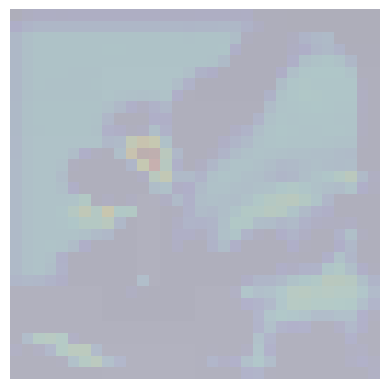

In [7]:
img_dir = Path.cwd() / "../images"
img = Image.open(img_dir / "real_proc" / "0002.jpg").convert("L")
plt.imshow(img, cmap='gray')
plt.axis('off')

img_n = np.array(img, dtype=np.float32) / 255.0  # shape (H, W)
img_n = torch.from_numpy(img_n.copy()).unsqueeze(0).unsqueeze(0)
heatmap = gradcam(img_n)
plt.imshow(heatmap, cmap='jet', alpha=0.1)
plt.axis('off')
plt.show()

In [8]:
# CUSTOM COLOURMAP
from matplotlib.colors import LinearSegmentedColormap
CMAP = LinearSegmentedColormap.from_list(
    "transparent_yellow_red",
    [
        (0.0, (1.0, 1.0, 0.0, 0.0)),  # transparent yellow
        (0.7, (1.0, 1.0, 0.0, 1.0)),  # yellow
        (1.0, (1.0, 0.0, 0.0, 1.0)),  # red
    ],
)

real_proc, model prob: 0.00, st_sigmoid_prob: 0.00


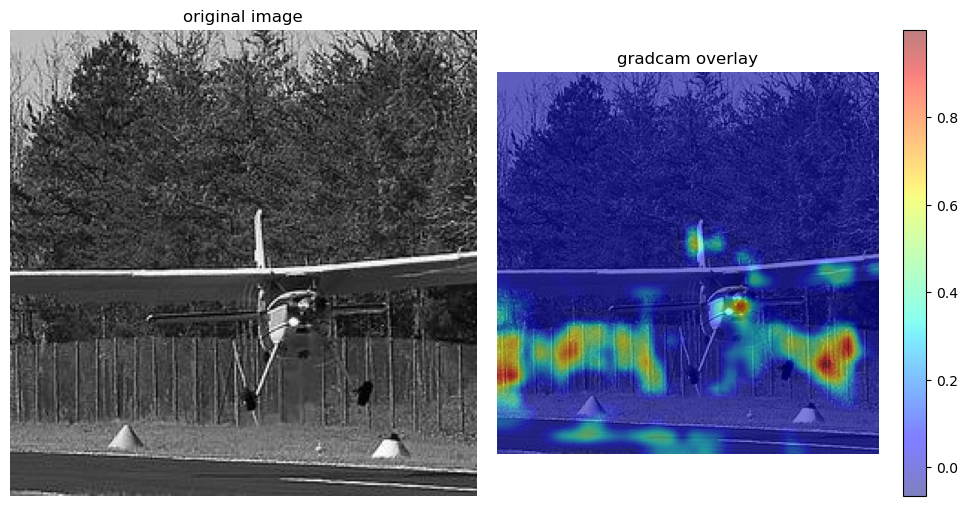

gen_proc, model prob: 0.90, st_sigmoid_prob: 1.00


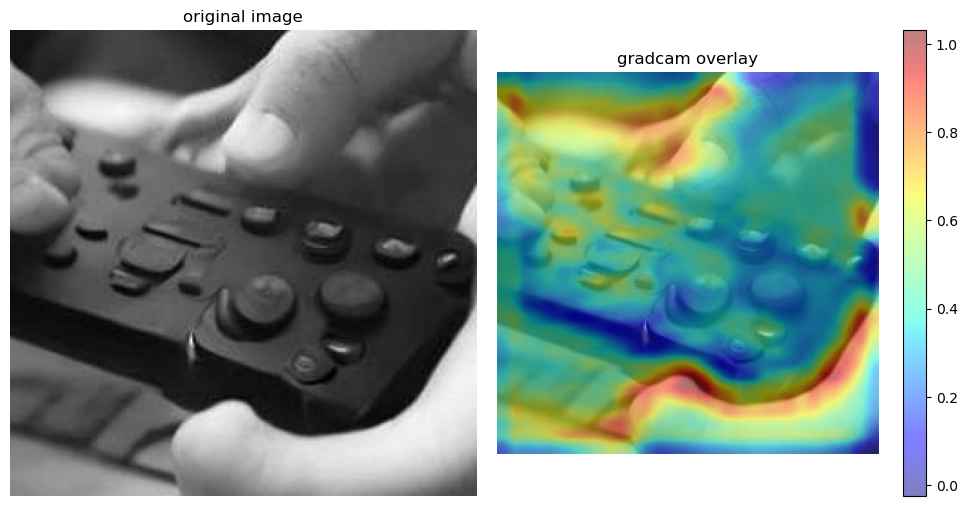

real_proc, model prob: 0.10, st_sigmoid_prob: 0.00


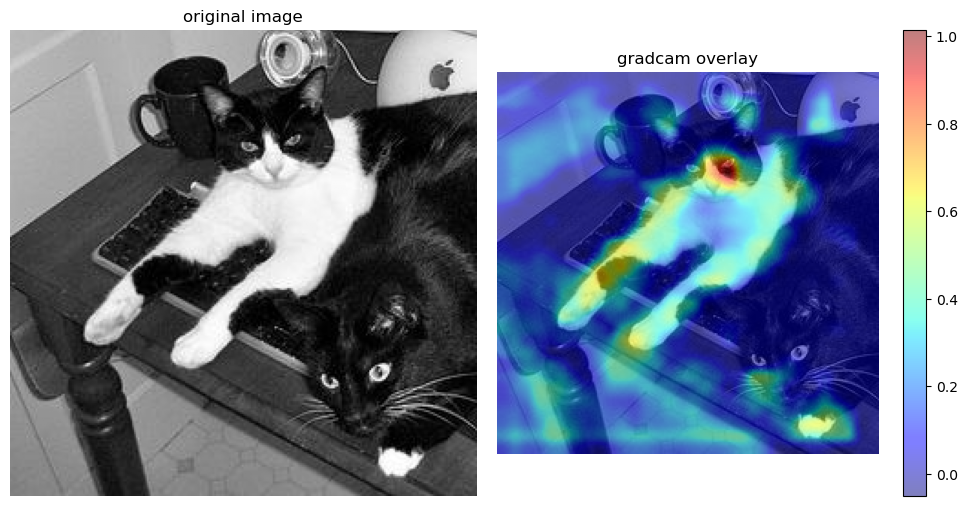

gen_proc, model prob: 0.90, st_sigmoid_prob: 1.00


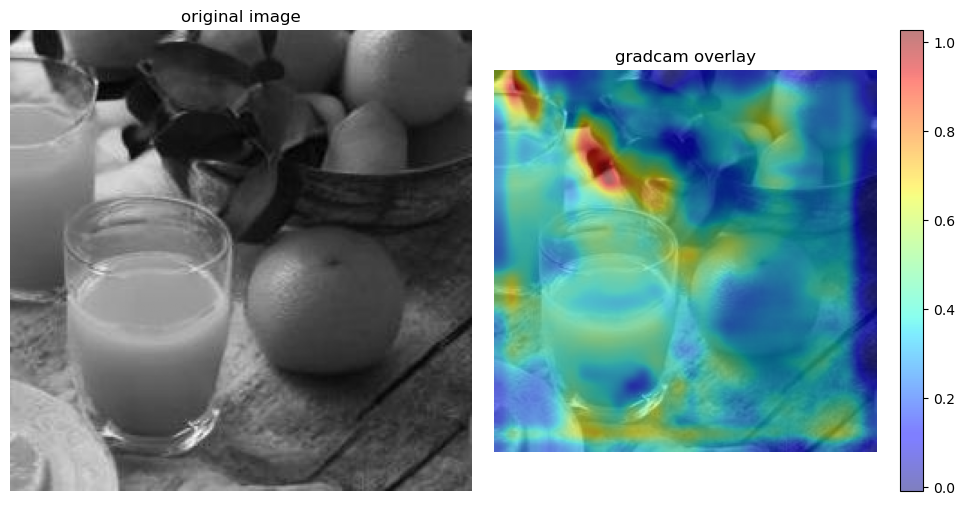

real_proc, model prob: 0.34, st_sigmoid_prob: 0.08


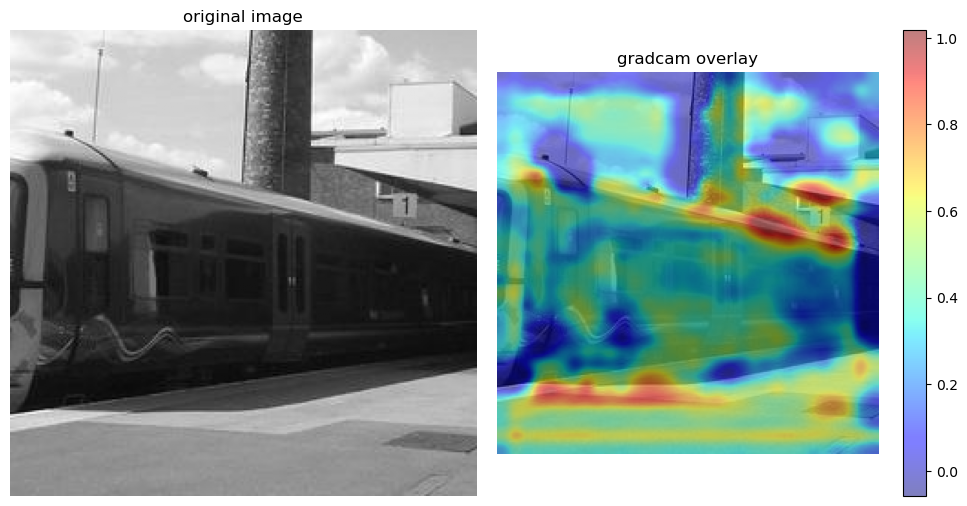

gen_proc, model prob: 0.53, st_sigmoid_prob: 0.62


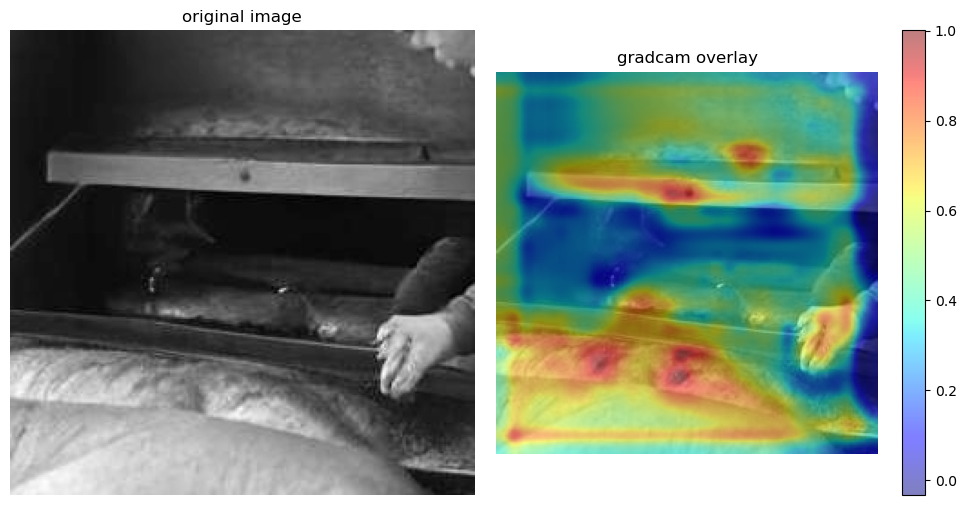

real_proc, model prob: 0.00, st_sigmoid_prob: 0.00


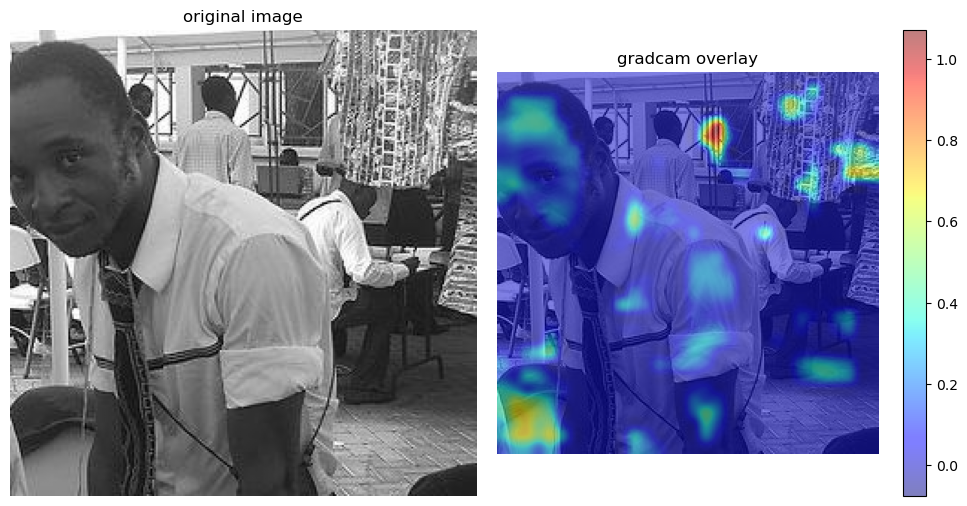

gen_proc, model prob: 0.69, st_sigmoid_prob: 0.94


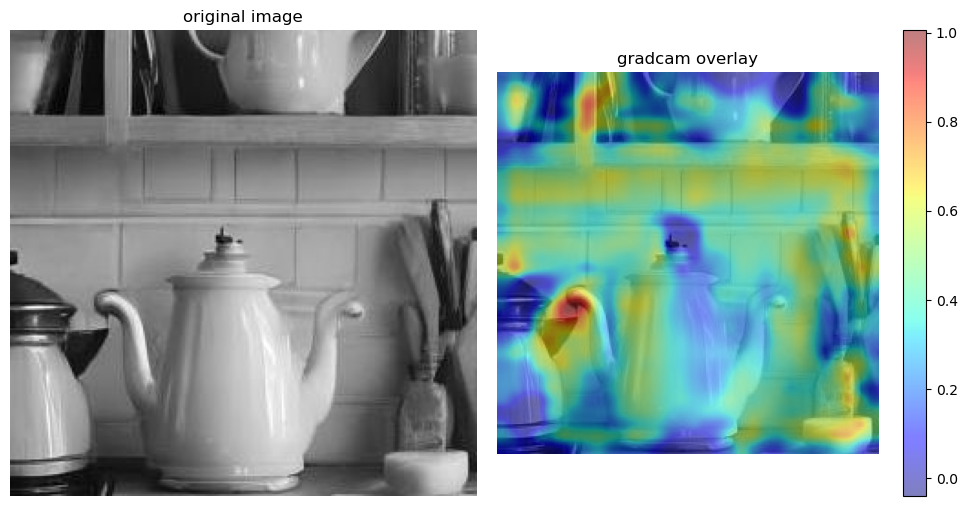

real_proc, model prob: 0.58, st_sigmoid_prob: 0.77


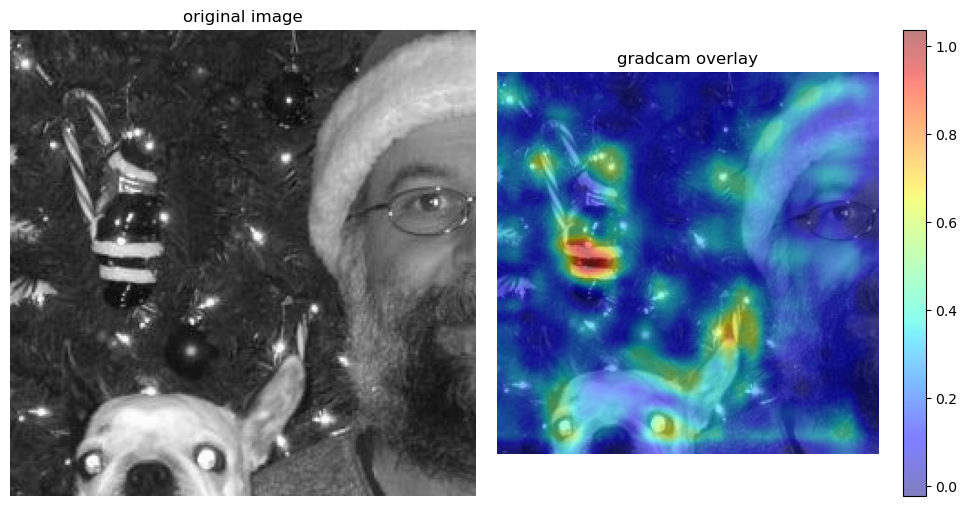

gen_proc, model prob: 0.81, st_sigmoid_prob: 0.99


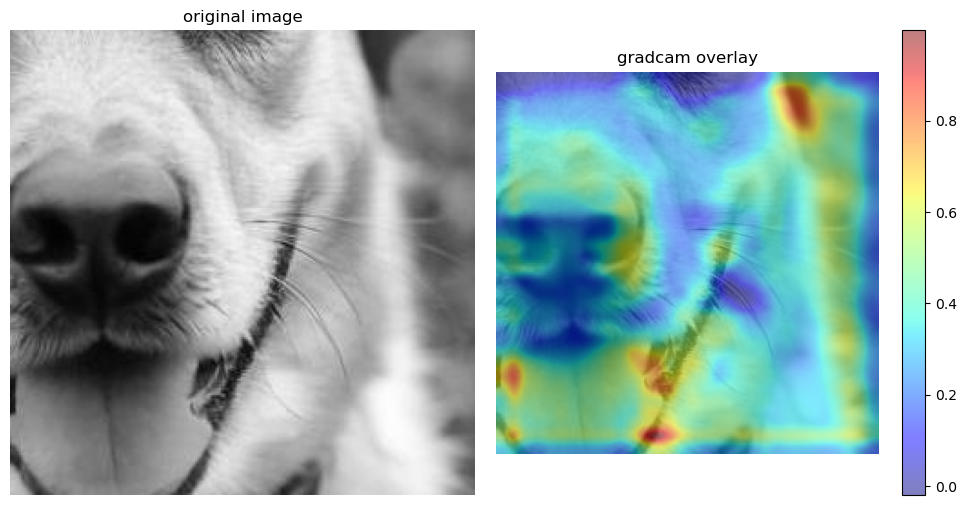

In [9]:
for i in range(10):
    i += 80

    img_dir = Path.cwd() / "../images"
    choice = "real_proc" if i % 2 == 0 else "gen_proc"
    img = Image.open(img_dir / choice / f"00{i}.jpg").convert("L")
    img_array = np.array(img, dtype=np.float32) / 255.0  # normalize 0-1

    # preprocess for model
    img_n = torch.from_numpy(img_array.copy()).unsqueeze(0).unsqueeze(0)
    heatmap = gradcam(img_n).squeeze()  # shape HxW

    # normalize heatmap to 0-1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # resize heatmap to match original image size if necessary
    if heatmap.shape != img_array.shape:
        heatmap = np.array(Image.fromarray(heatmap).resize(img_array.shape[::-1]))

    def steep_sigmoid(x, k=15):
        return 1 / (1 + np.exp(-k * (x - 0.5)))

    with torch.no_grad():
        logits = model(img_n)
        prob = torch.sigmoid(logits)
    prob = float(prob)
    print(f"{choice}, model prob: {prob:.2f}, st_sigmoid_prob: {steep_sigmoid(prob):.2f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # original grayscale image
    axes[0].imshow(img_array, cmap='gray')
    axes[0].set_title('original image')
    axes[0].axis('off')

    # overlay heatmap
    axes[1].imshow(img_array, cmap='gray')
    # axes[1].imshow(heatmap, cmap='jet', alpha=steep_sigmoid(prob)*0.5)
    axes[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[1].set_title('gradcam overlay')
    axes[1].axis('off')

    fig.colorbar(axes[1].images[-1], ax=axes[1])

    plt.tight_layout()
    plt.show()

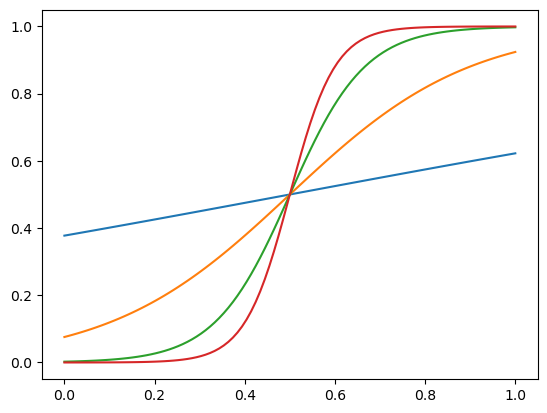

In [10]:
x = np.linspace(0, 1, 100)

def steep_sigmoid(x, k=12):
    return 1 / (1 + np.exp(-k * (x - 0.5)))

plt.plot(x, steep_sigmoid(x, k=1))
plt.plot(x, steep_sigmoid(x, k=5))
plt.plot(x, steep_sigmoid(x, k=12))
plt.plot(x, steep_sigmoid(x, k=20))
plt.show()